In [74]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import random
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

In [75]:
df = pd.read_csv("Data/merged_tk2025_dataset.csv")
df.columns

Index(['gemeente_naam', 'population',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GRIJZE_DRUK_pct',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GROENE_DRUK_pct',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_TOTALE_DRUK_pct',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_10_TOT_15_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_15_TOT_20_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_20_TOT_25_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_25_TOT_45_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEFTIJDSGROEPEN_45_TOT_65_JAAR_AANTAL_count',
       'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_LEEF

Convert gender count to percentage

In [76]:
df["women_share"] = (df["women_count"] / (df["men_count"] + df["women_count"])) * 100
df["men_share"]   = (df["men_count"]   / (df["men_count"] + df["women_count"])) * 100

In [77]:
age_count_cols = [c for c in df.columns if c.startswith("age_") and c.endswith("_count")]

age_relatief_cols = [c for c in df.columns if c.startswith("age_") and "LEEFTIJDSGROEPEN_RELATIEF" in c and c.endswith("_pct")]

total_pressure_col = [
    c for c in df.columns
    if c.startswith("age_") and "DEMOGRAFISCHE_DRUK_TOTALE_DRUK" in c and c.endswith("_pct")
]

gender_count_cols = ["men_count", "women_count"]

men_col = ["men_share"]  # keep women_share

cols_to_drop = age_count_cols + age_relatief_cols + total_pressure_col + gender_count_cols + men_col + ["avg_income_household"] + ["num_households"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

In [78]:
df.rename(columns={'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GRIJZE_DRUK_pct': 'grijze_druk_pct', 
                   'age_BEVOLKING_BEVOLKINGSSAMENSTELLING_OP_1_JANUARI_LEEFTIJD_DEMOGRAFISCHE_DRUK_GROENE_DRUK_pct': 'groene_druk_pct'}, inplace=True)

In [79]:
#only 5 missing values in total
df.dropna(inplace=True)

In [80]:
econ_target_columns = [col for col in df.columns if col.startswith("econ_") and col.endswith("_share_pct")]
migration_target_columns = [col for col in df.columns if col.startswith("mig_") and col.endswith("_share_pct")]
votes_columns = [col for col in df.columns if col.endswith("_share_pct")]

Economics regressions

In [81]:
X = df.drop(columns=econ_target_columns + migration_target_columns + votes_columns +["gemeente_naam"]) 
y = df[econ_target_columns[0]]  
X_with_const = sm.add_constant(X)

model_econ_centerleft = sm.OLS(y, X_with_const).fit()
print(model_econ_centerleft.summary())

                                OLS Regression Results                               
Dep. Variable:     econ_CENTERLEFT_share_pct   R-squared:                       0.422
Model:                                   OLS   Adj. R-squared:                  0.409
Method:                        Least Squares   F-statistic:                     33.33
Date:                       Tue, 16 Dec 2025   Prob (F-statistic):           1.05e-34
Time:                               10:22:48   Log-Likelihood:                -845.08
No. Observations:                        328   AIC:                             1706.
Df Residuals:                            320   BIC:                             1737.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

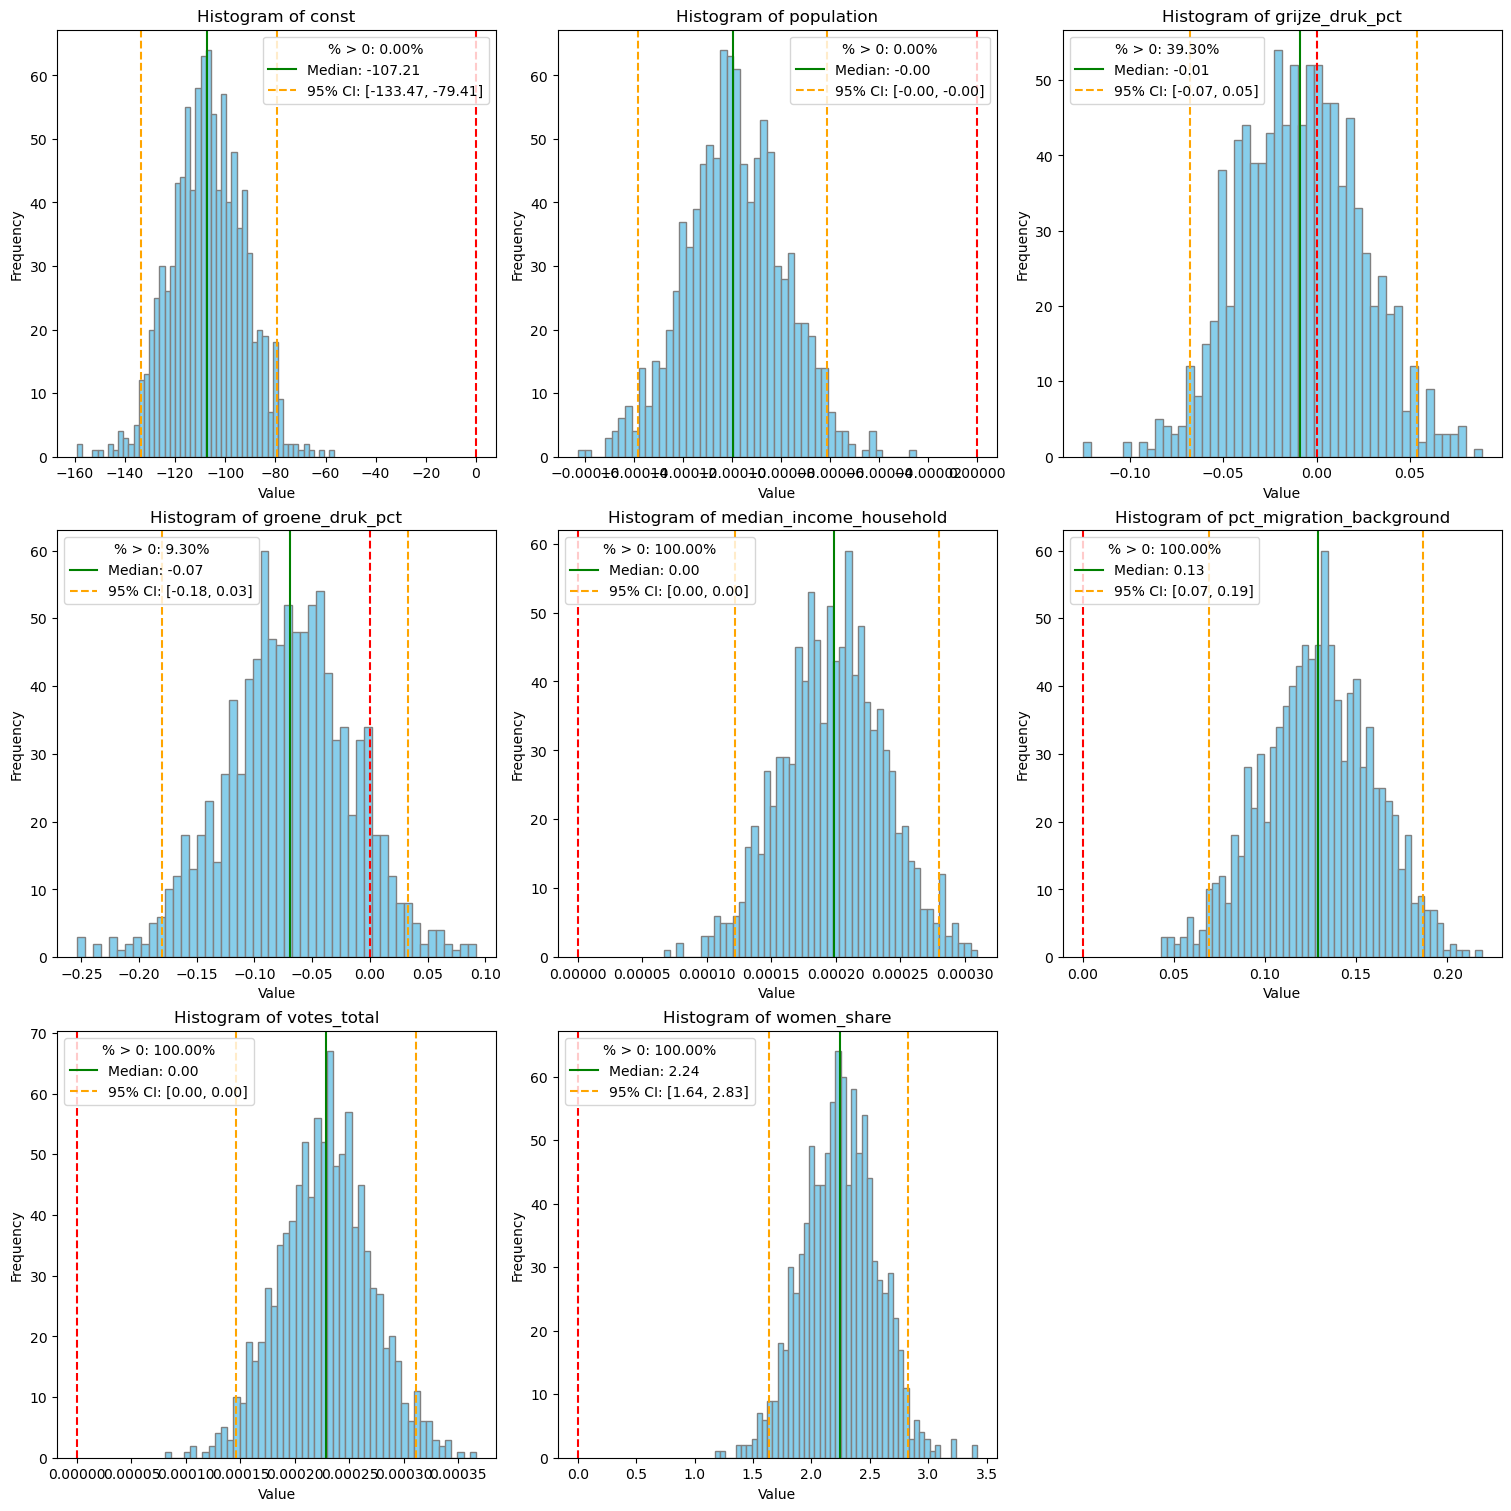

In [82]:
coeff_samples = np.random.multivariate_normal(model_econ_centerleft.params, model_econ_centerleft.cov_params(), 1000)

parameter_names = model_econ_centerleft.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

In [83]:
y = df[econ_target_columns[1]]  

model_econ_centerright = sm.OLS(y, X_with_const).fit()
print(model_econ_centerright.summary())

                                OLS Regression Results                                
Dep. Variable:     econ_CENTERRIGHT_share_pct   R-squared:                       0.625
Model:                                    OLS   Adj. R-squared:                  0.617
Method:                         Least Squares   F-statistic:                     76.20
Date:                        Tue, 16 Dec 2025   Prob (F-statistic):           2.15e-64
Time:                                10:22:48   Log-Likelihood:                -952.72
No. Observations:                         328   AIC:                             1921.
Df Residuals:                             320   BIC:                             1952.
Df Model:                                   7                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

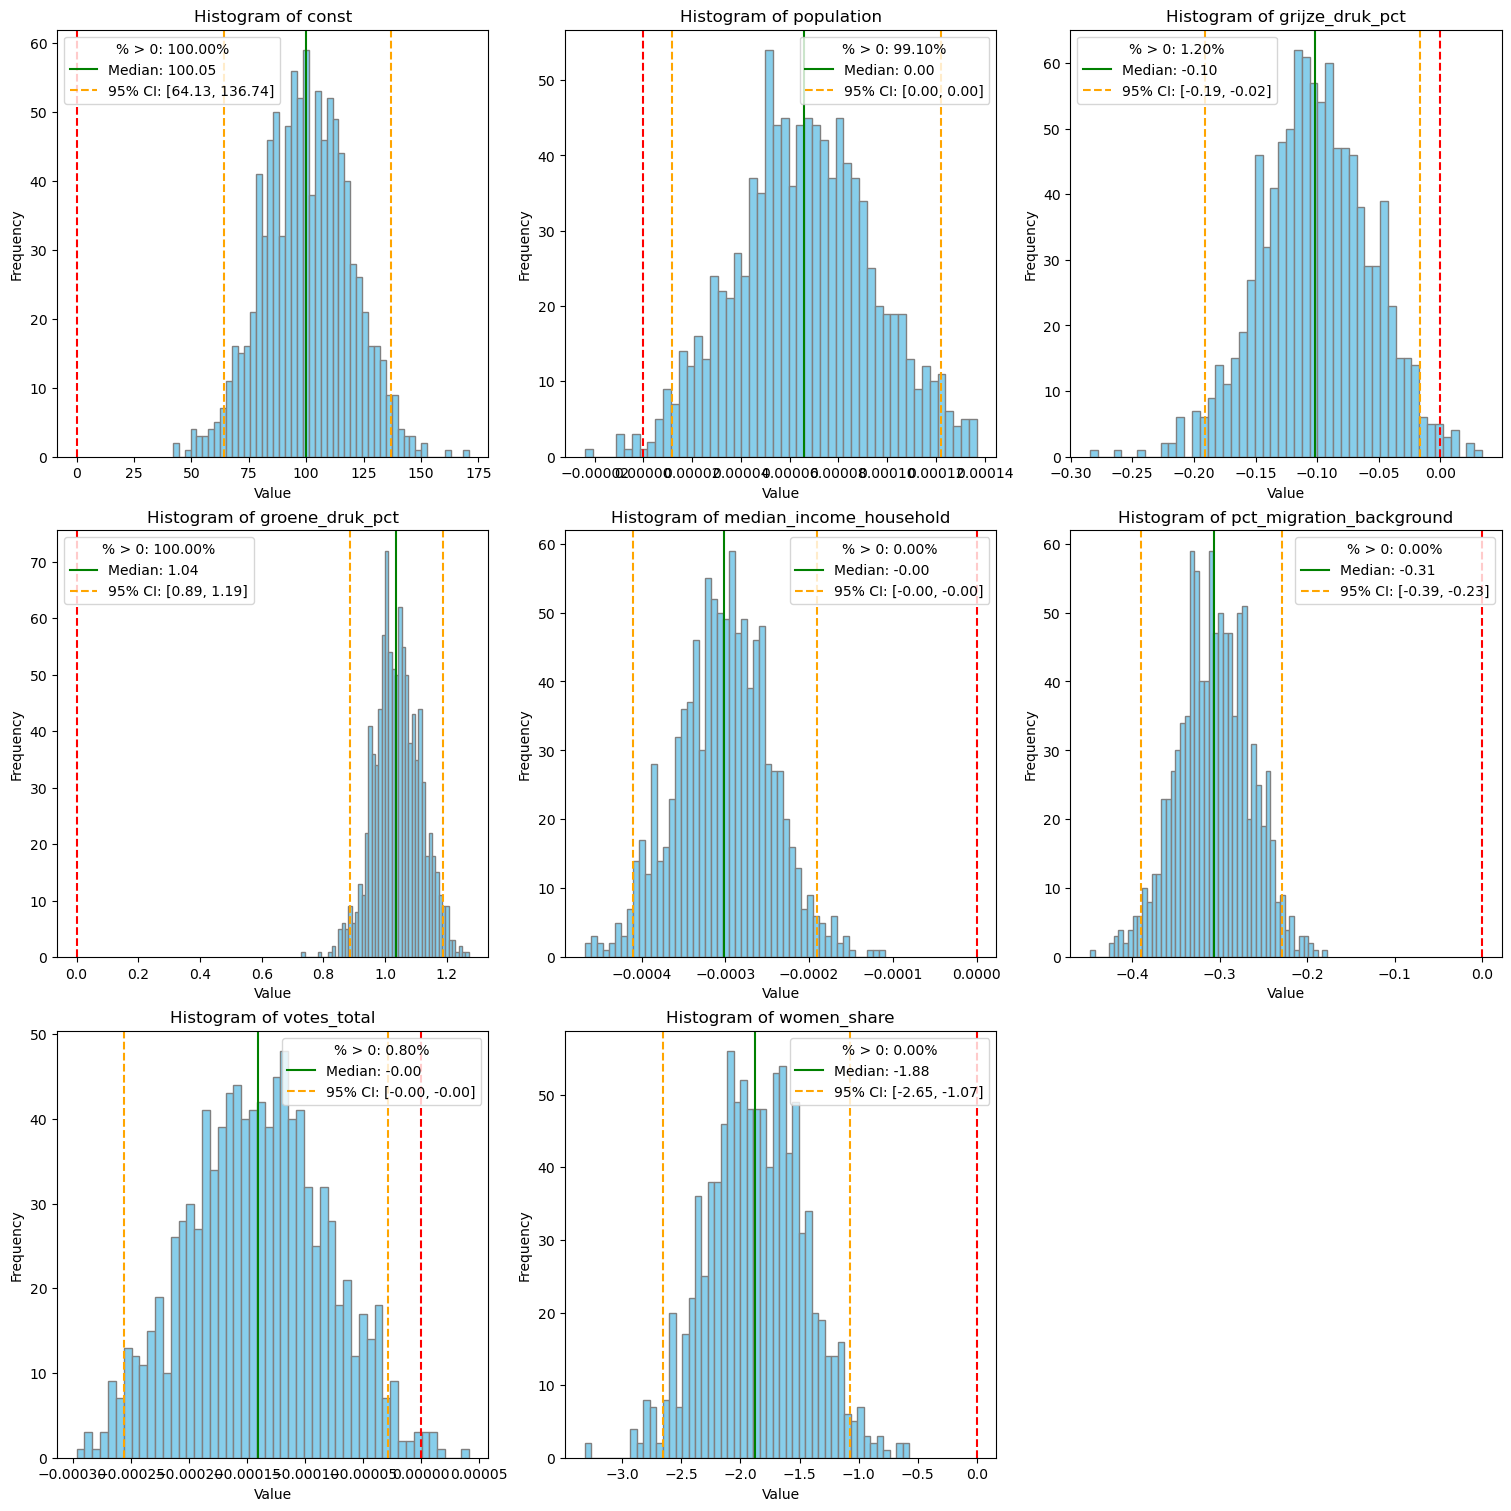

In [90]:
coeff_samples = np.random.multivariate_normal(model_econ_centerright.params, model_econ_centerright.cov_params(), 1000)

parameter_names = model_econ_centerright.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

In [84]:
y = df[econ_target_columns[2]]  

model_econ_left = sm.OLS(y, X_with_const).fit()
print(model_econ_left.summary())

                             OLS Regression Results                            
Dep. Variable:     econ_LEFT_share_pct   R-squared:                       0.621
Model:                             OLS   Adj. R-squared:                  0.613
Method:                  Least Squares   F-statistic:                     74.86
Date:                 Tue, 16 Dec 2025   Prob (F-statistic):           1.24e-63
Time:                         10:22:48   Log-Likelihood:                -926.62
No. Observations:                  328   AIC:                             1869.
Df Residuals:                      320   BIC:                             1900.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

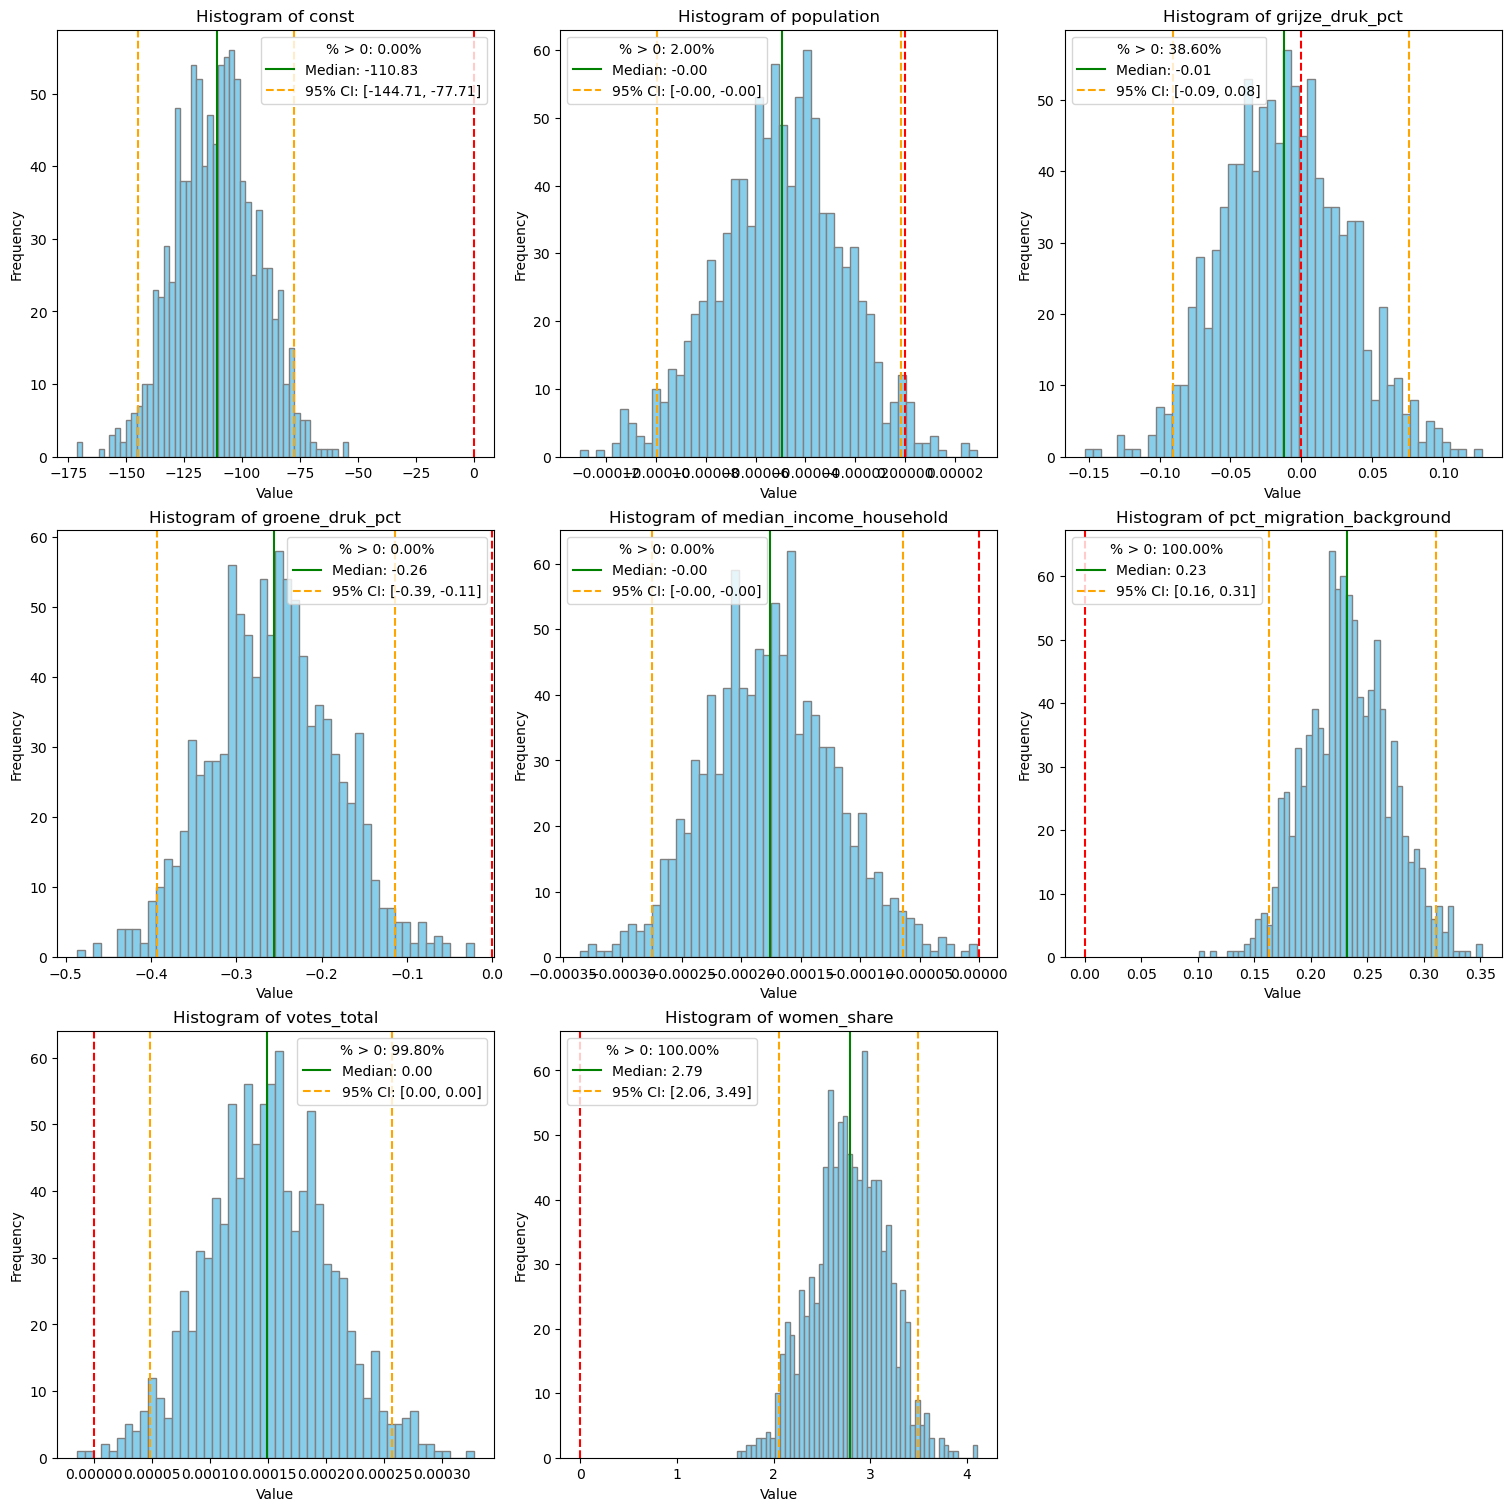

In [91]:
coeff_samples = np.random.multivariate_normal(model_econ_left.params, model_econ_left.cov_params(), 1000)

parameter_names = model_econ_left.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

In [85]:
y = df[econ_target_columns[3]]  

model_econ_right = sm.OLS(y, X_with_const).fit()
print(model_econ_right.summary())

                             OLS Regression Results                             
Dep. Variable:     econ_RIGHT_share_pct   R-squared:                       0.416
Model:                              OLS   Adj. R-squared:                  0.403
Method:                   Least Squares   F-statistic:                     32.55
Date:                  Tue, 16 Dec 2025   Prob (F-statistic):           4.99e-34
Time:                          10:22:48   Log-Likelihood:                -1052.9
No. Observations:                   328   AIC:                             2122.
Df Residuals:                       320   BIC:                             2152.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

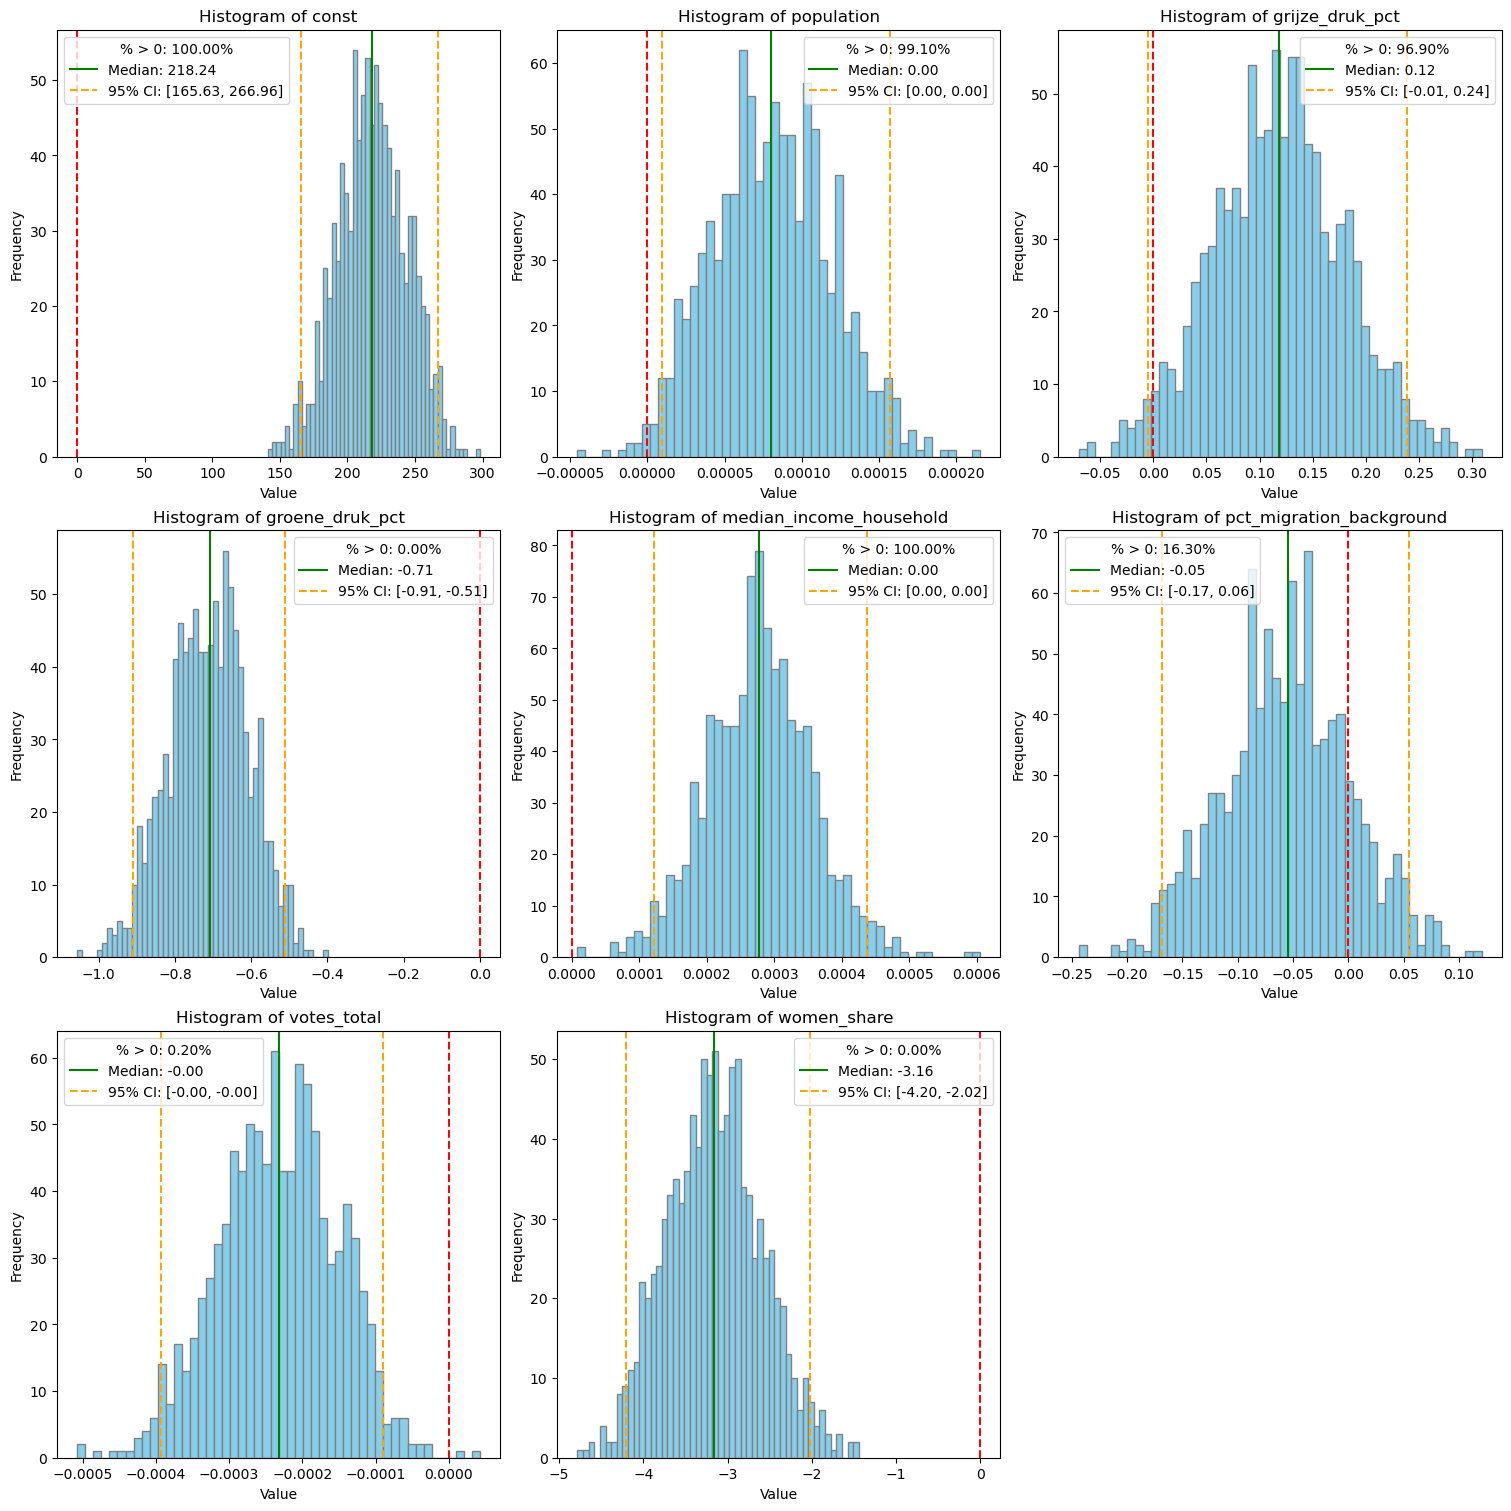

In [92]:
coeff_samples = np.random.multivariate_normal(model_econ_right.params, model_econ_right.cov_params(), 1000)

parameter_names = model_econ_right.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

Migration regressions

In [86]:
y = df[migration_target_columns[0]]  

model_migration_conservative = sm.OLS(y, X_with_const).fit()
print(model_migration_conservative.summary())

                                OLS Regression Results                                
Dep. Variable:     mig_CONSERVATIVE_share_pct   R-squared:                       0.652
Model:                                    OLS   Adj. R-squared:                  0.645
Method:                         Least Squares   F-statistic:                     85.71
Date:                        Tue, 16 Dec 2025   Prob (F-statistic):           1.44e-69
Time:                                10:22:48   Log-Likelihood:                -911.48
No. Observations:                         328   AIC:                             1839.
Df Residuals:                             320   BIC:                             1869.
Df Model:                                   7                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

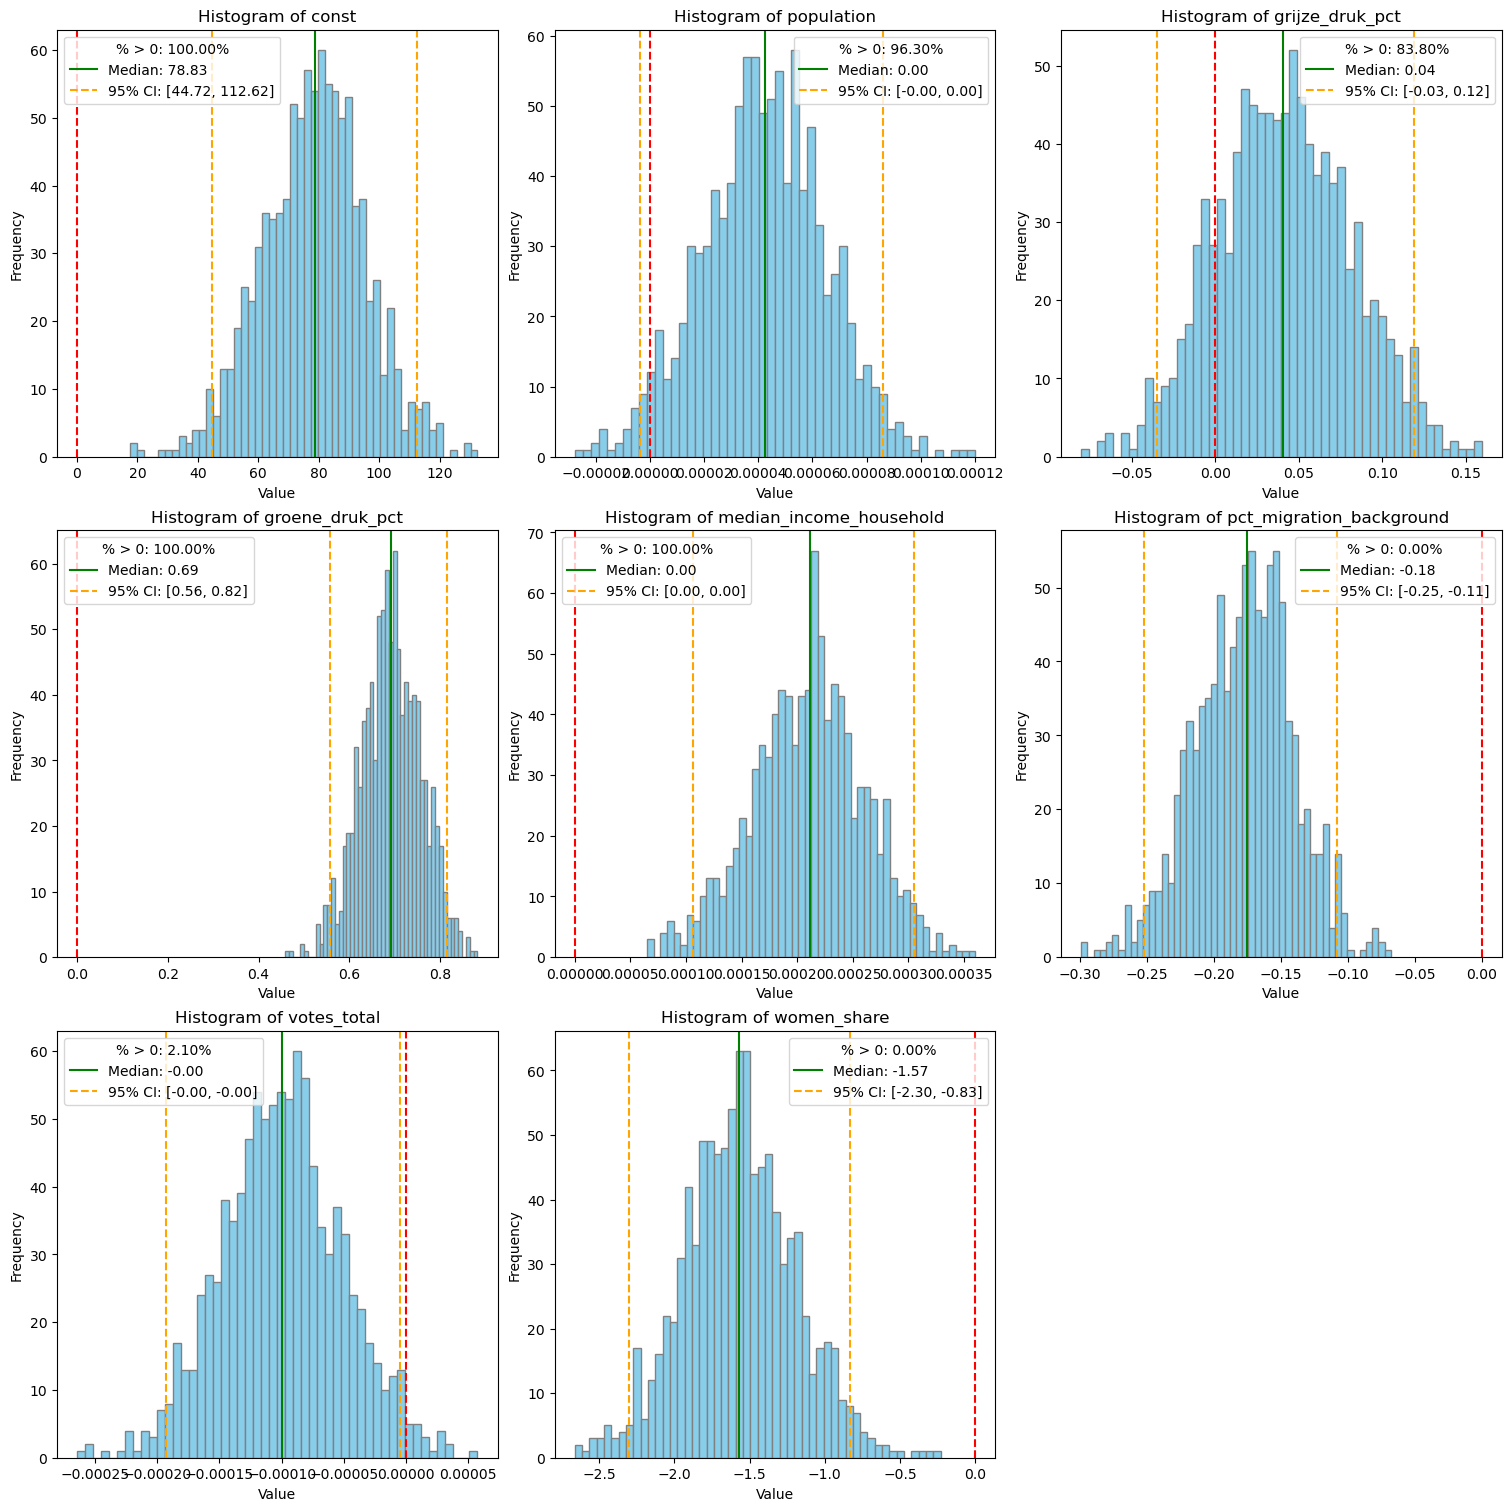

In [93]:
coeff_samples = np.random.multivariate_normal(model_migration_conservative.params, model_migration_conservative.cov_params(), 1000)

parameter_names = model_migration_conservative.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

In [87]:
y = df[migration_target_columns[1]]  

model_migration_extreme_conservative = sm.OLS(y, X_with_const).fit()
print(model_migration_extreme_conservative.summary())

                                    OLS Regression Results                                    
Dep. Variable:     mig_EXTREME_CONSERVATIVE_share_pct   R-squared:                       0.417
Model:                                            OLS   Adj. R-squared:                  0.404
Method:                                 Least Squares   F-statistic:                     32.64
Date:                                Tue, 16 Dec 2025   Prob (F-statistic):           4.14e-34
Time:                                        10:22:48   Log-Likelihood:                -1030.8
No. Observations:                                 328   AIC:                             2078.
Df Residuals:                                     320   BIC:                             2108.
Df Model:                                           7                                         
Covariance Type:                            nonrobust                                         
                               coef    std err    

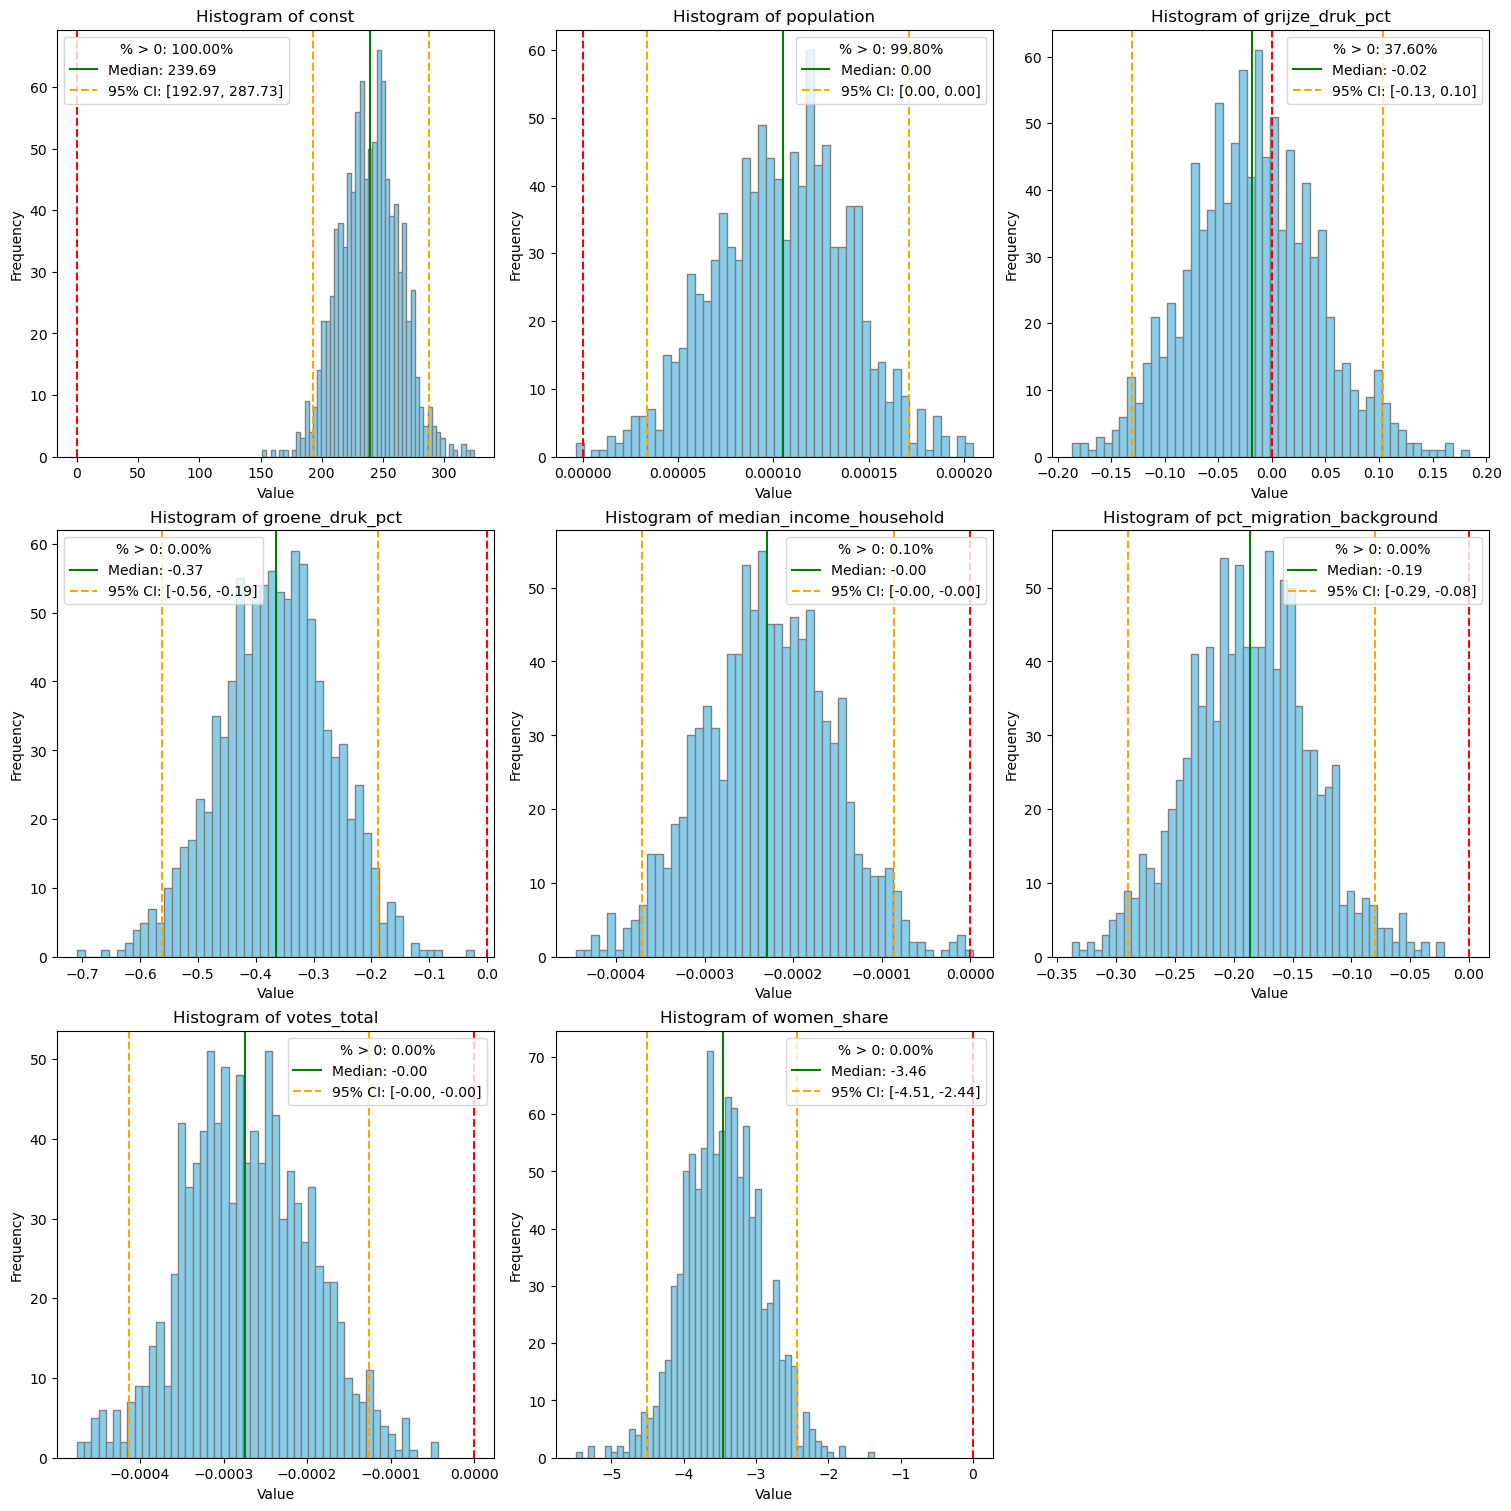

In [94]:
coeff_samples = np.random.multivariate_normal(model_migration_extreme_conservative.params, model_migration_extreme_conservative.cov_params(), 1000)

parameter_names = model_migration_extreme_conservative.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

In [88]:
y = df[migration_target_columns[2]]  

model_migration_extreme_progressive = sm.OLS(y, X_with_const).fit()
print(model_migration_extreme_progressive.summary())

                                    OLS Regression Results                                   
Dep. Variable:     mig_EXTREME_PROGRESSIVE_share_pct   R-squared:                       0.520
Model:                                           OLS   Adj. R-squared:                  0.509
Method:                                Least Squares   F-statistic:                     49.51
Date:                               Tue, 16 Dec 2025   Prob (F-statistic):           2.03e-47
Time:                                       10:22:48   Log-Likelihood:                -907.29
No. Observations:                                328   AIC:                             1831.
Df Residuals:                                    320   BIC:                             1861.
Df Model:                                          7                                         
Covariance Type:                           nonrobust                                         
                               coef    std err          t   

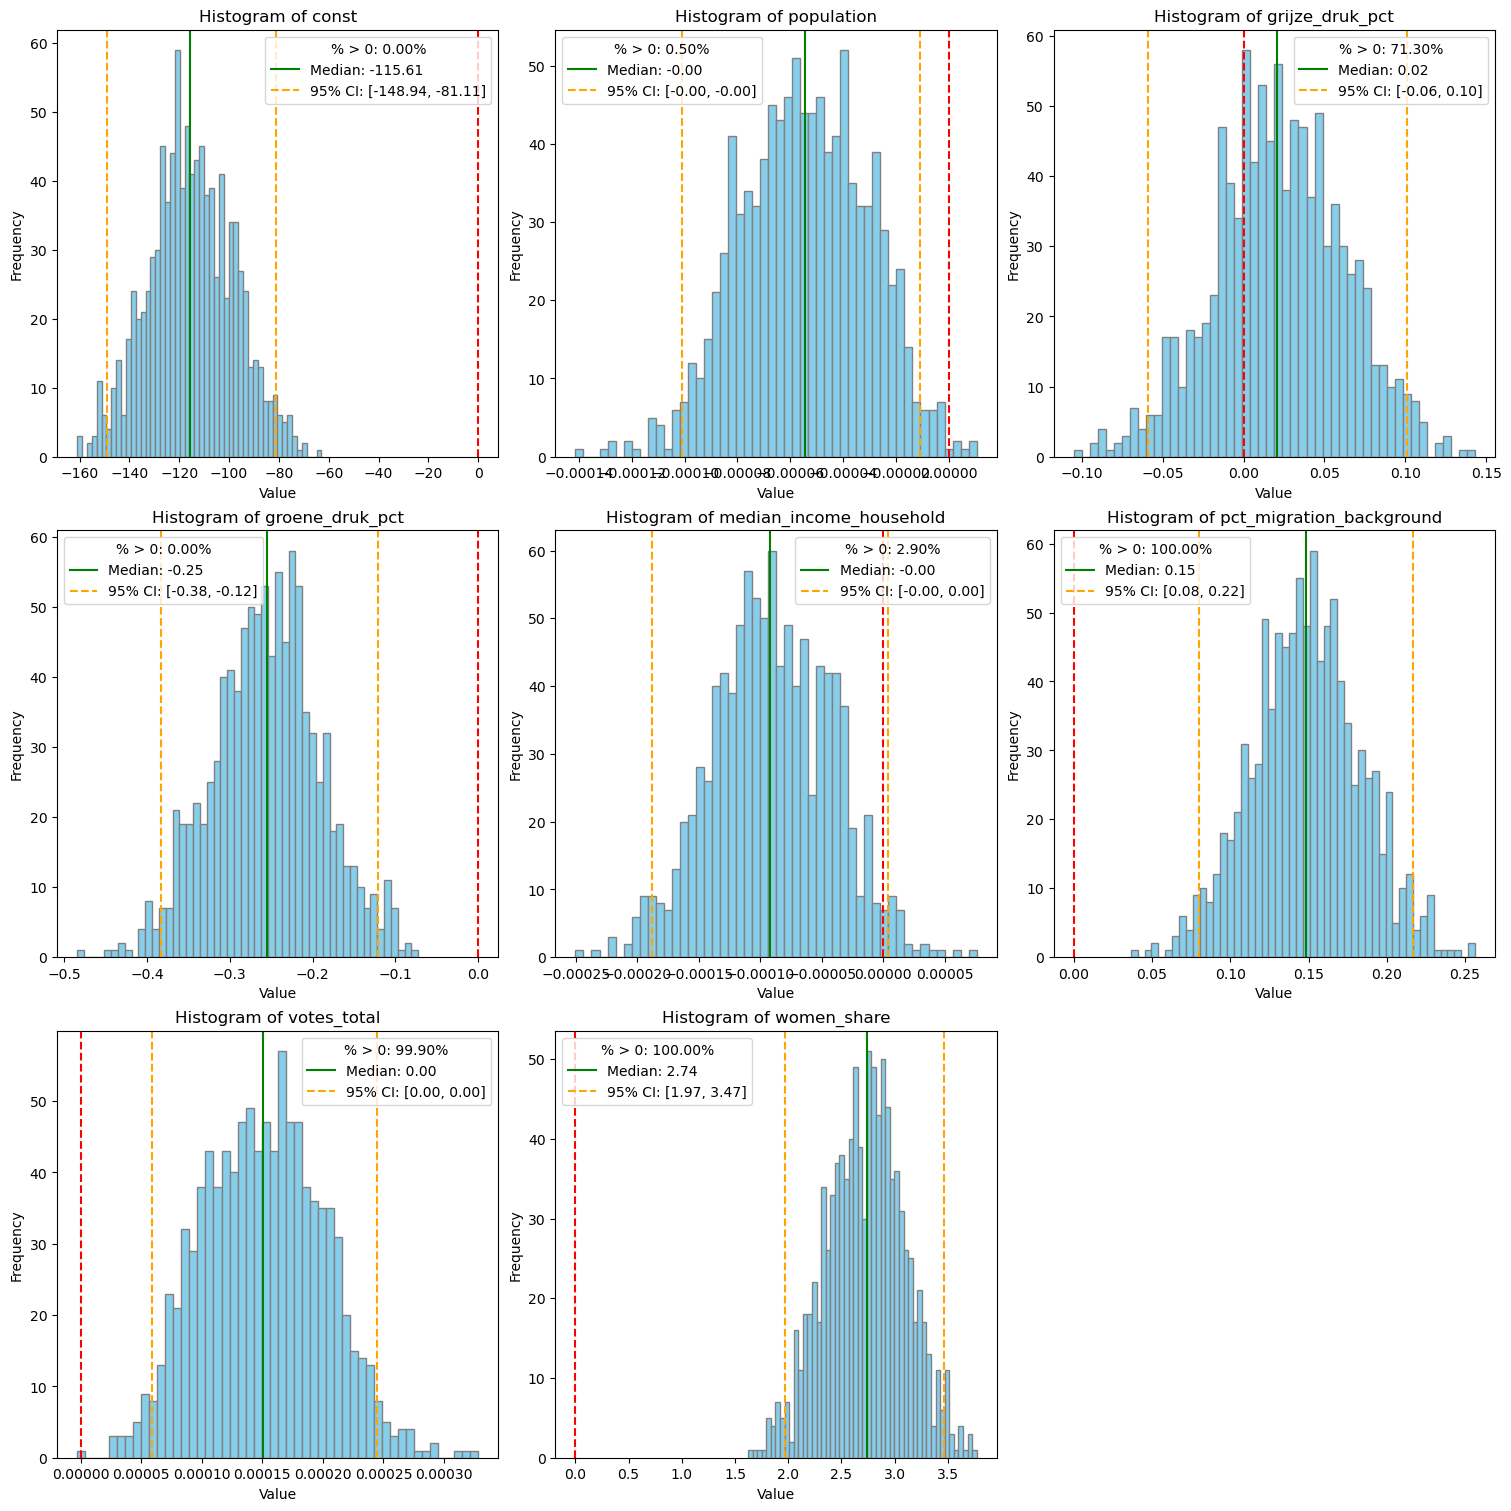

In [95]:
coeff_samples = np.random.multivariate_normal(model_migration_extreme_progressive.params, model_migration_extreme_progressive.cov_params(), 1000)

parameter_names = model_migration_extreme_progressive.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

In [89]:
y = df[migration_target_columns[3]]  

model_migration_progressive = sm.OLS(y, X_with_const).fit()
print(model_migration_progressive.summary())

                                OLS Regression Results                               
Dep. Variable:     mig_PROGRESSIVE_share_pct   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.518
Method:                        Least Squares   F-statistic:                     51.20
Date:                       Tue, 16 Dec 2025   Prob (F-statistic):           1.25e-48
Time:                               10:22:48   Log-Likelihood:                -866.60
No. Observations:                        328   AIC:                             1749.
Df Residuals:                            320   BIC:                             1780.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

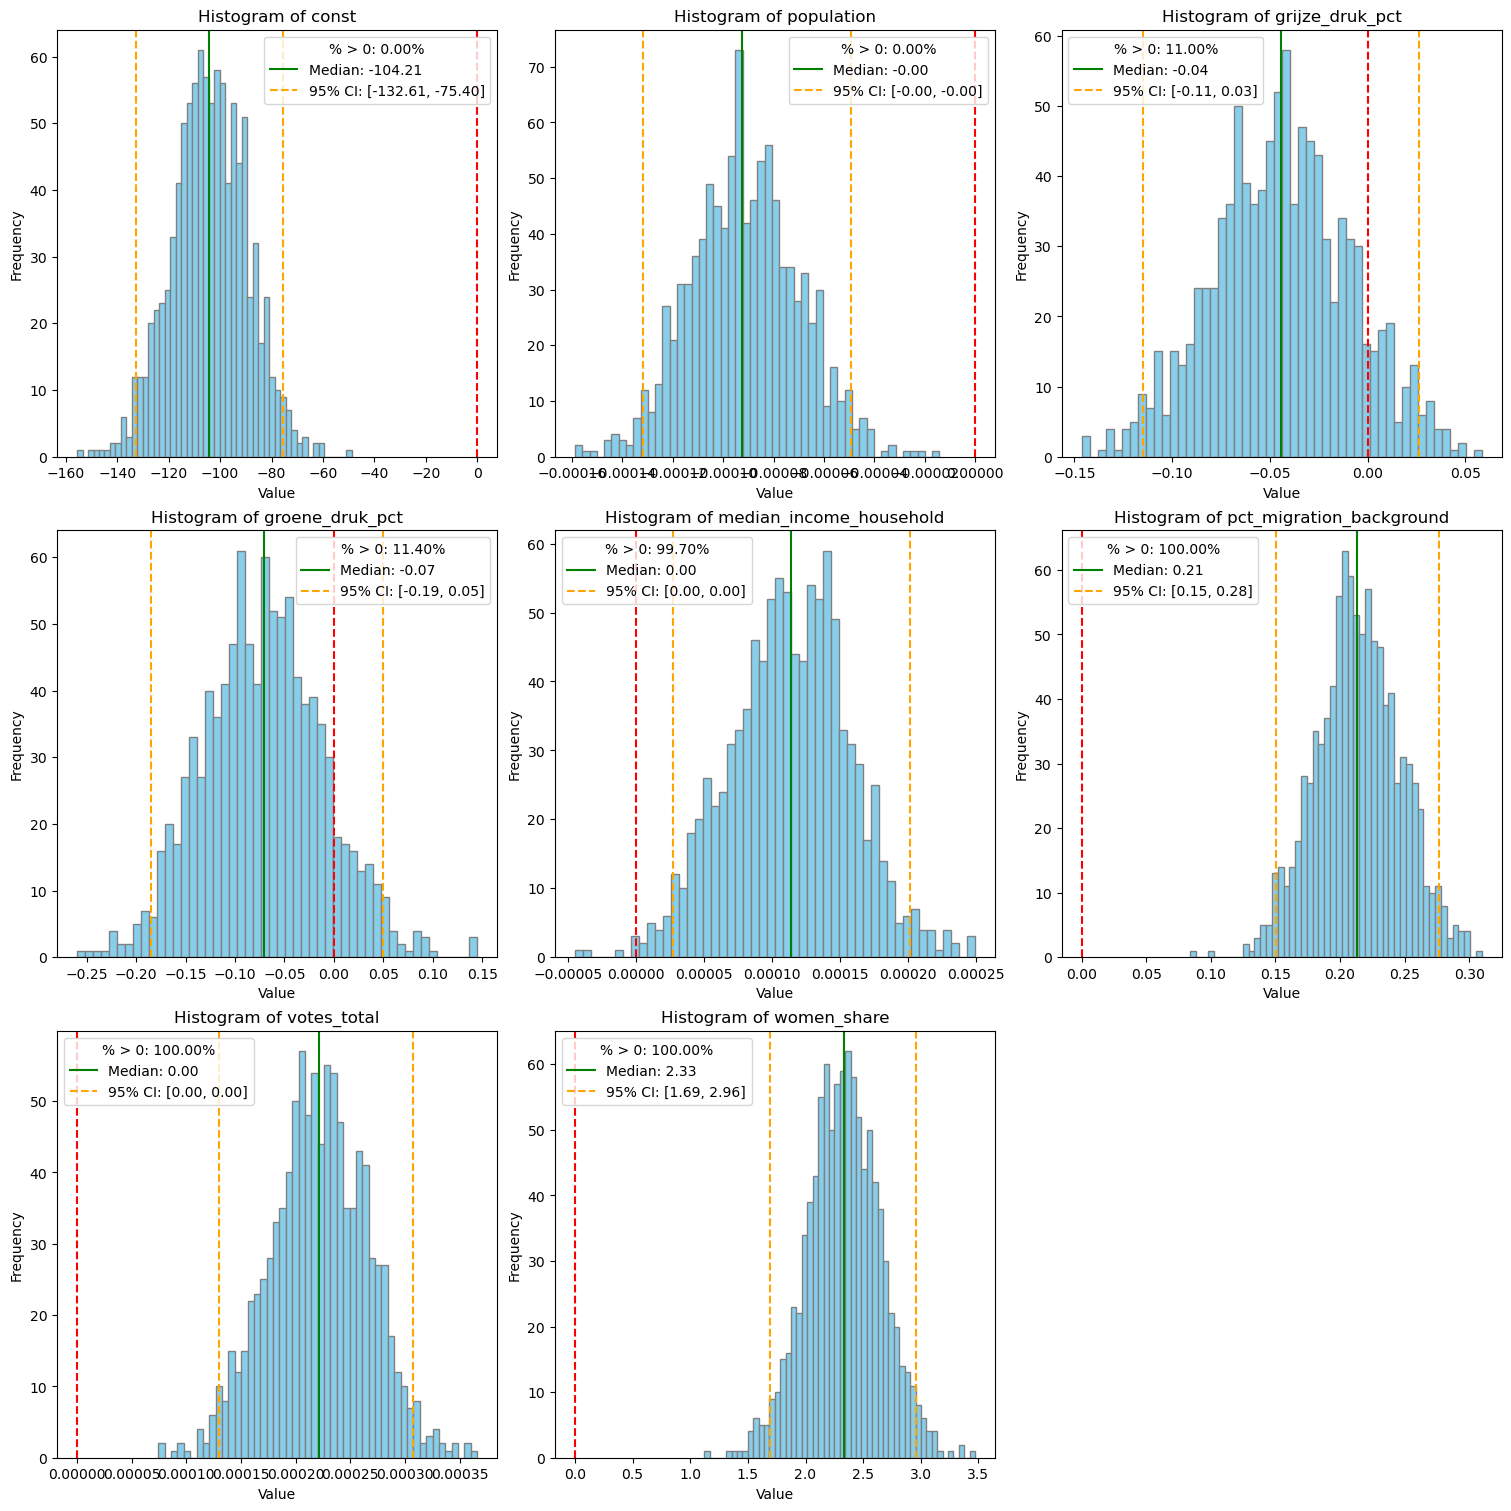

In [96]:
coeff_samples = np.random.multivariate_normal(model_migration_progressive.params, model_migration_progressive.cov_params(), 1000)

parameter_names = model_migration_progressive.params.index.tolist()
n_params = len(parameter_names)

n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()